<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Navid Farmahini Farahani
### Student ID: 401210923

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 147110252.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 92258715.78it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 48269039.19it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5992616.79it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

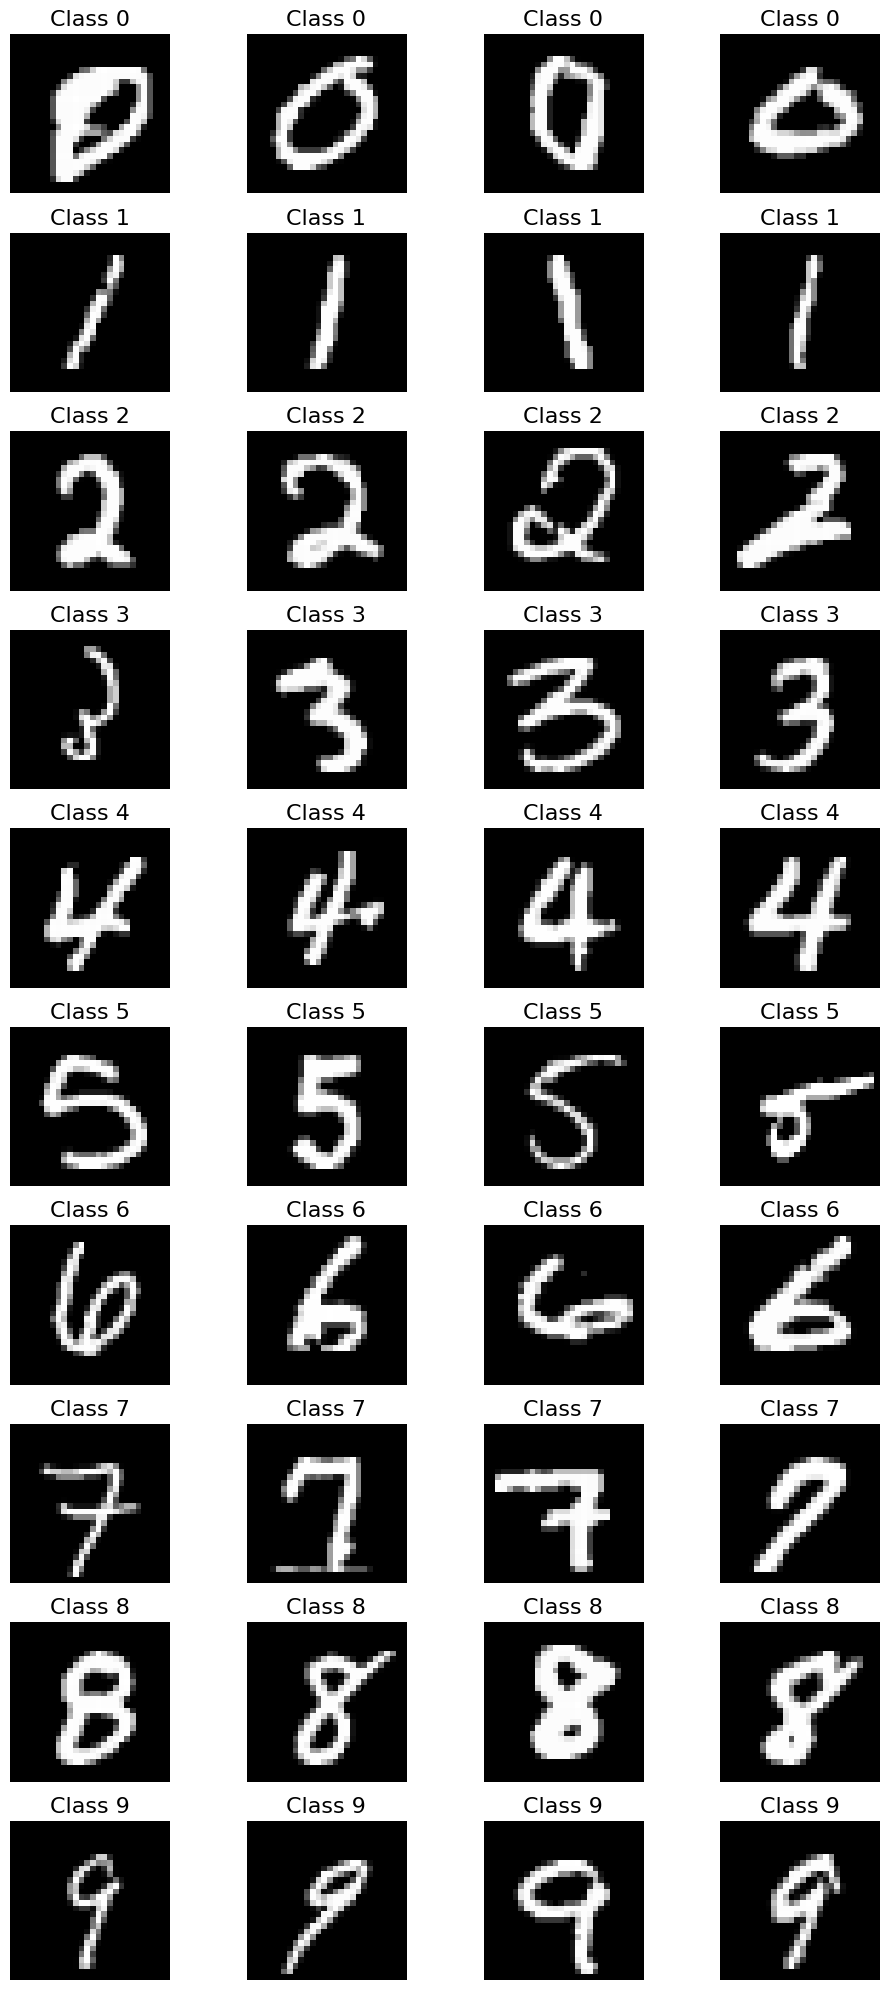

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        # Defining the variables into theirselves.

        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.latent_dim=latent_dim# For MNIST, this variable is 10

        # We want to design an MLP, so we need nn.Linear and a an activation function after each layer.
        # Note that we considered some hidden layers for encoder, we will consider them adversly in decoder.

        self.encoder=nn.Sequential(nn.Linear(self.input_dim,self.hidden_dim[0]),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim[0],self.hidden_dim[1]),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim[1],self.hidden_dim[2]),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim[2],self.hidden_dim[3]),
                                     )
        # We need to define 2 mu's and 2 var's because of the latent space
        # But we consider var's as logvar, because of better mathematical formulations(in PDFs of Dr.Fatemizadeh)
        # Also, this variable can be every number, but variance can just be positive, so we don't have to use nn.ReLU after var

        self.fc_mu=nn.Linear(self.hidden_dim[3],latent_dim)
        self.fc_logvar=nn.Linear(self.hidden_dim[3],latent_dim)

        # Now, we should design the decoder, buf before that, we have to map the latent space to the hidden layers of the decoder.
        # because size of latent space is not equal to the first hidden layer of the decoder necessary.
        # Thus, we have to design an MLP, so we use nn.Linear again for this mapping.

        # Note that we consider nn.Sigmoid() for the last actication function
        # Because MNIST data can be considered as Binary data and we can set the output as 0 and 1 and use Crossentropy loss
        # as the loss function

        self.decoder=nn.Sequential(nn.Linear(latent_dim,self.hidden_dim[3]),
                                    nn.Linear(self.hidden_dim[3],self.hidden_dim[2]),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim[2],self.hidden_dim[1]),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim[1],self.hidden_dim[0]),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim[0],self.input_dim),
                                    nn.Sigmoid()
                                    )


    def reparameterize(self, mu, logvar):
        # According to PDF of Dr.Fatemizadeh we can construct the latent space:

        var=torch.exp(logvar)
        std=torch.sqrt(var)
        eps=torch.randn(size=std.shape)
        eps=eps.to(device)
        z=mu+torch.multiply(eps,std)
        return z

    def forward(self, x):
        x=self.encoder(x)

        mu=self.fc_mu(x) # Calculation of mu and var(We have 2 mus and vars)
        logvar=self.fc_logvar(x) # Calculation of mu and var(We have 2 mus and vars)

        z=self.reparameterize(mu,logvar) # Construct the latent space

        out=self.decoder(z)

        return out, mu, logvar

In [6]:

# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    # we use cross entropy loss for all the data in a batch for loss function, because MNIST
    # is a binary data (the pixels are zero or one, we normalize data later)


    reconstruction_loss = torch.nn.functional.binary_cross_entropy(recon,data, reduction='sum')

    # TODO: Implement the KL divergence loss

    # According to PDF of Dr.Fatemizadeh, we have:

    KL_divergence=0.5*torch.sum(torch.exp(logvar)+mu**2-1-logvar)

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses

    loss=reconstruction_loss+KL_divergence
    return loss


In [7]:

# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value

    best_model = None
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss=0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            data = data/torch.max(data)# We normalize the data

            input_data = torch.reshape(data,(-1,784))

            recon, mu, logvar = model.forward(input_data)
            # TODO: Flatten the data and recon tensors
            data = torch.flatten(data)
            recon = torch.flatten(recon)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss

        avg_loss = total_loss/len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

         # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample=sample.to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model.state_dict(), 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 11700.6240234375
Sample Images:


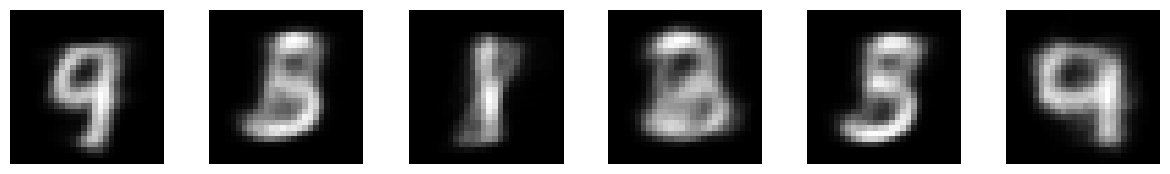


##################################################
VAE-MLP Epoch [2/10], Loss: 9924.0244140625
Sample Images:


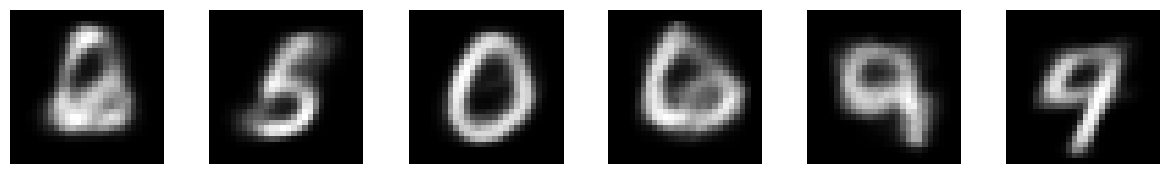


##################################################
VAE-MLP Epoch [3/10], Loss: 9531.044921875
Sample Images:


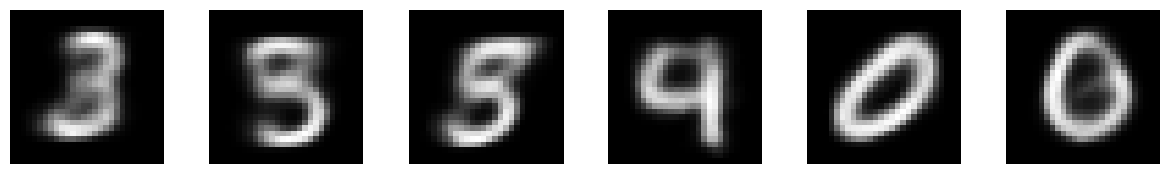


##################################################
VAE-MLP Epoch [4/10], Loss: 9368.55859375
Sample Images:


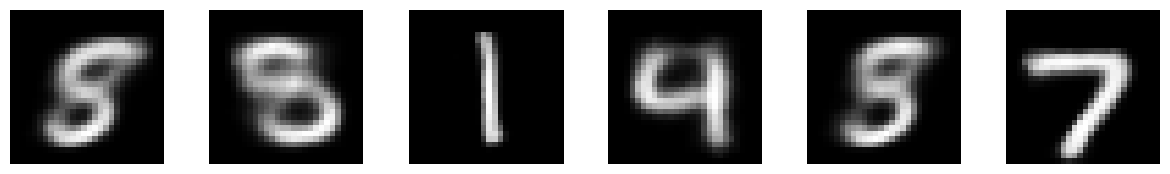


##################################################
VAE-MLP Epoch [5/10], Loss: 9243.412109375
Sample Images:


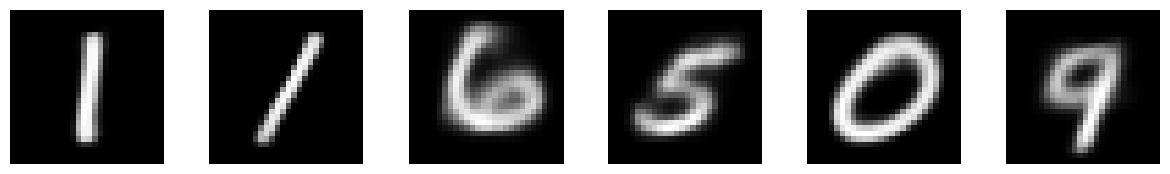


##################################################
VAE-MLP Epoch [6/10], Loss: 9177.275390625
Sample Images:


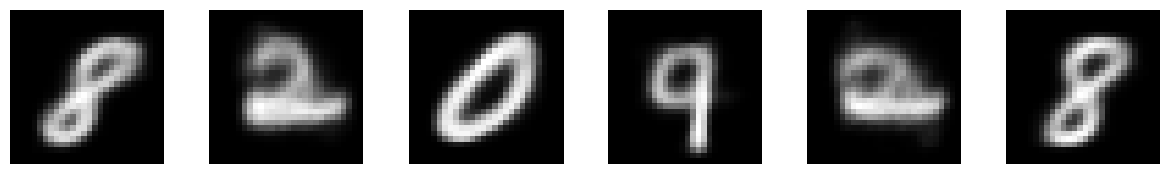


##################################################
VAE-MLP Epoch [7/10], Loss: 9096.515625
Sample Images:


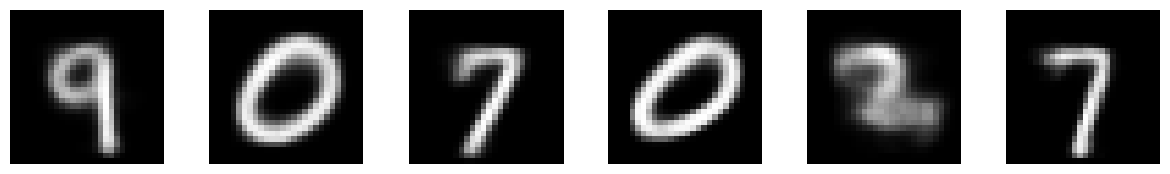


##################################################
VAE-MLP Epoch [8/10], Loss: 9104.1826171875
Sample Images:


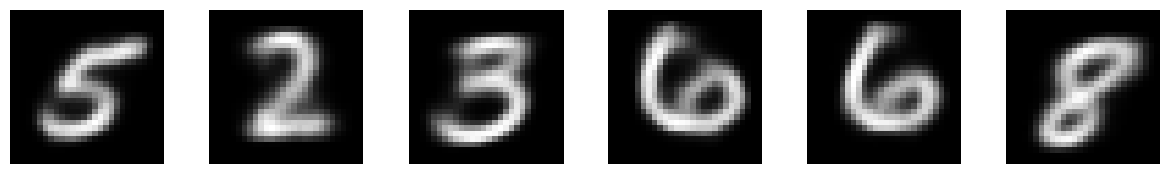


##################################################
VAE-MLP Epoch [9/10], Loss: 9045.5654296875
Sample Images:


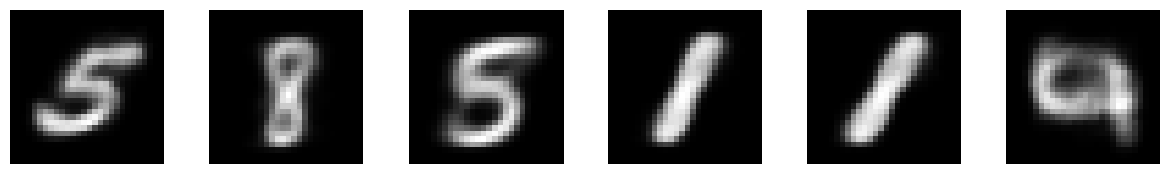


##################################################
VAE-MLP Epoch [10/10], Loss: 9006.779296875
Sample Images:


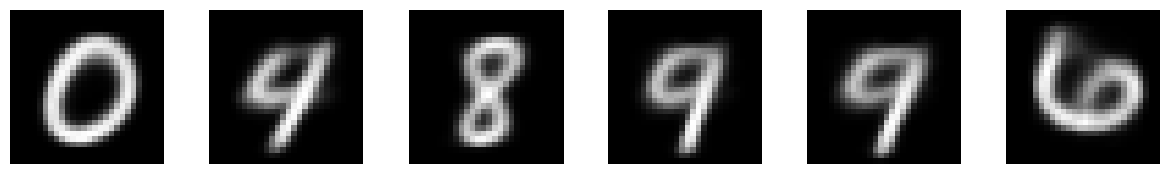

Best model saved as 'best_vae_mlp_model.pth'


In [8]:



def to_device(data, device):
    # for every batch, we pass the data to the current device.
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl=dl
        self.device=device

    def __iter__(self):
        #For every batch, we pass it to the current device.
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

# Selecting the current device
if torch.cuda.is_available():
      device=torch.device('cuda')
else:
      device=torch.device('cpu')


# Train VAE-MLP
train_loader=DeviceDataLoader(train_loader,device)# passing all the data to device using DeviceDataLoader class
vae_mlp=VAE_MLP(28*28,[512,256,128,64],2)# Choosing model
vae_mlp=to_device(vae_mlp,device)# passing model to device using DeviceDataLoader class



train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [9]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        # This time, we should define num_classes, too because for the latentspace we will have 2 concatenations

        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.latent_dim=latent_dim
        self.num_classes=num_classes
        self.fc_class=nn.Linear(self.hidden_dim[3],self.num_classes)

        # This part is completely similar to VAE, but we have input_dim+num_classes (or 794) input features
        # because we have to concatenate the labels and images

        self.encoder=nn.Sequential(# TODO: Add layers for the encoder
                                   nn.Linear(self.input_dim+self.num_classes,self.hidden_dim[0]),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim[0],self.hidden_dim[1]),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim[1],self.hidden_dim[2]),
                                     nn.ReLU(),
                                     nn.Linear(self.hidden_dim[2],self.hidden_dim[3]),
                                     )

        # Identical to VAE
        self.fc_mu=nn.Linear(self.hidden_dim[3],latent_dim)
        self.fc_logvar=nn.Linear(self.hidden_dim[3],latent_dim)




        # TODO: Define the architecture of the decoder

        # Identical to VAE
        self.decoder=nn.Sequential(# TODO: Add layers for the decoder
                                    nn.Linear(self.latent_dim+self.num_classes,self.hidden_dim[3]),
                                    nn.Linear(self.hidden_dim[3],self.hidden_dim[2]),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim[2],self.hidden_dim[1]),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim[1],self.hidden_dim[0]),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim[0],self.input_dim),
                                    nn.Sigmoid()
                                    )

        # Identical to VAE
    def reparameterize(self, mu, logvar):
        var=torch.exp(logvar)
        std=torch.sqrt(var)
        eps=torch.randn(size=std.shape)
        eps=eps.to(device)
        z=mu+torch.multiply(eps,std)
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.concat((x,y),dim=1) # We concatenate labels and flattened images

        # TODO: Implement the forward pass

        hidden=self.encoder(x)# Identical to VAE
        mu=self.fc_mu(hidden) # Identical to VAE
        logvar=self.fc_logvar(hidden)# Identical to VAE
        z=self.reparameterize(mu,logvar) # Identical to VAE
        class_logits=self.fc_class(hidden) # Similar to mu and logvar, this time we have class_logits, but the number of them is 10
        # because for MNIST we have 10 classes, so we need to use the encoder outputs to construct 10 features for classes.

        z=torch.concat((z,y),dim=1)# In the decoder part, we have to concatenate labels to latent space again, so the dimension will be 2+10=12

        reconstructed=self.decoder(z)# Identical to VAE


        return reconstructed, mu, logvar, class_logits



In [10]:

# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(data.size(0), -1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = torch.nn.functional.binary_cross_entropy(recon,data, reduction='sum')# Identical to VAE


    # TODO: Implement the KL divergence loss
    kl_divergence=0.5*torch.sum(torch.exp(logvar)+mu**2-1-logvar)# Identical to VAE


    # TODO: Implement the cross-entropy loss for class prediction


    ce_loss = F.cross_entropy(class_logits, labels)# For class prediction, we use cross entropy, because we want to
    # compare labels and this is a classification problem

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    a=1
    b=1
    c=1

    # we can set weights to these losses, but I considered all of them 1.

    loss=(a*reconstruction_loss+b*kl_divergence+c*ce_loss)/(a+b+c)
    return loss


In [11]:

# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            data = data/torch.max(data)# We normalize the data

            input_data = torch.reshape(data,(-1,784))

            # One-hot encode the labels

            labels_one_hot=torch.zeros((len(labels),10))
            labels_one_hot=labels_one_hot.to(device)
            for i in range(len(labels_one_hot)):
                labels_one_hot[i,labels[i]]=1


            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar,class_logits = model.forward(input_data,labels_one_hot)

            # TODO: Calculate the loss using the vae_loss function

            loss=cvae_loss(recon, data, mu, logvar, class_logits, labels)
            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss

        avg_loss = total_loss/len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                z=z.to(device)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                y=y.to(device)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model.state_dict(), 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 3570.126220703125
Sample Images:


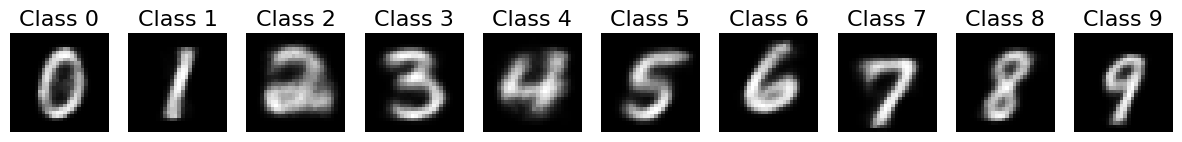


##################################################
CVAE-MLP Epoch [2/10], Loss: 2947.74755859375
Sample Images:


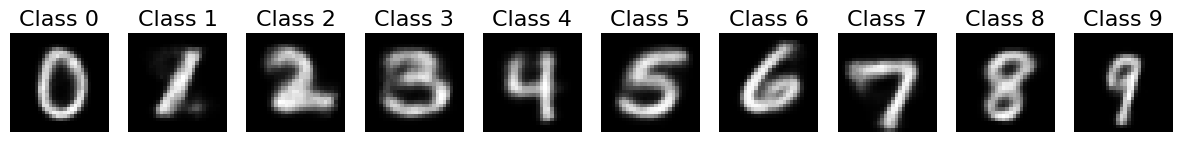


##################################################
CVAE-MLP Epoch [3/10], Loss: 2865.828125
Sample Images:


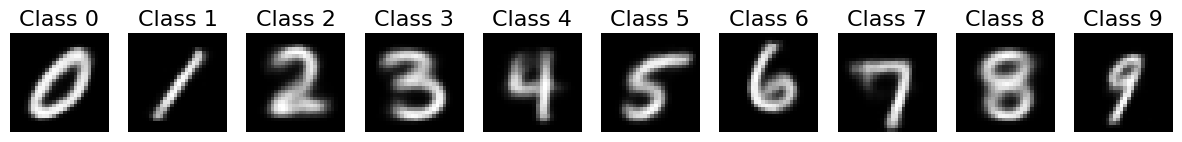


##################################################
CVAE-MLP Epoch [4/10], Loss: 2831.39208984375
Sample Images:


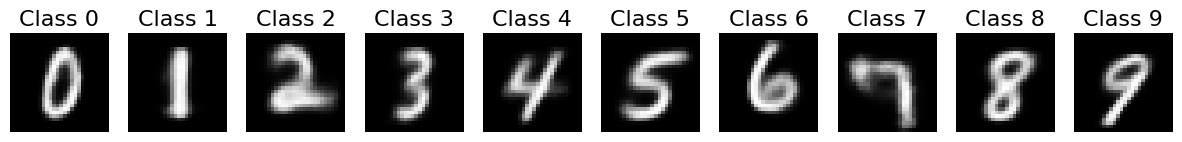


##################################################
CVAE-MLP Epoch [5/10], Loss: 2810.048828125
Sample Images:


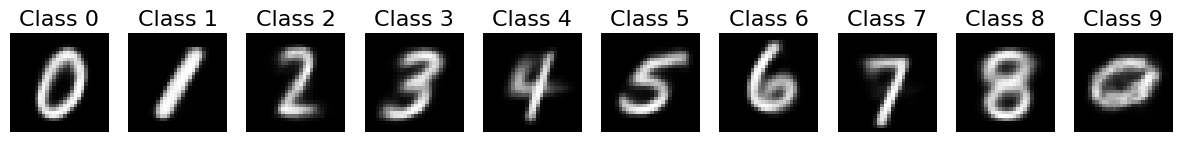


##################################################
CVAE-MLP Epoch [6/10], Loss: 2793.29638671875
Sample Images:


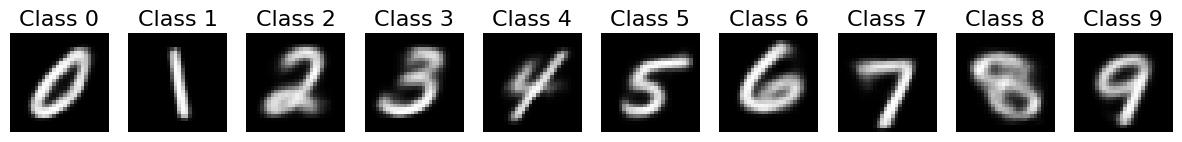


##################################################
CVAE-MLP Epoch [7/10], Loss: 2781.177001953125
Sample Images:


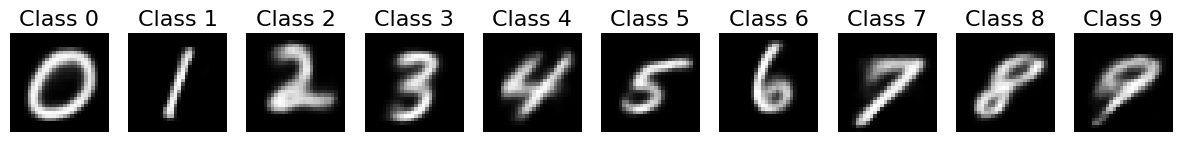


##################################################
CVAE-MLP Epoch [8/10], Loss: 2772.69384765625
Sample Images:


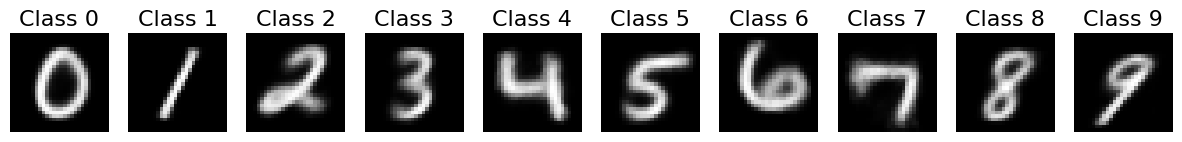


##################################################
CVAE-MLP Epoch [9/10], Loss: 2761.171875
Sample Images:


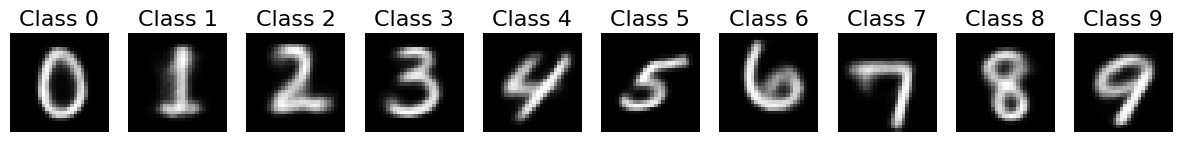


##################################################
CVAE-MLP Epoch [10/10], Loss: 2757.262939453125
Sample Images:


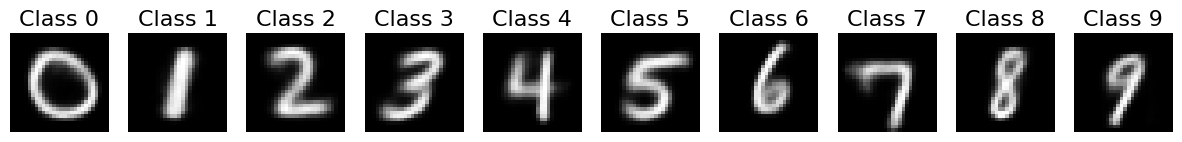

Best model saved as 'best_cvae_mlp_model.pth'


In [12]:
cvae_mlp=CVAE_MLP(28*28,[512,256,128,64],2,10)
cvae_mlp=to_device(cvae_mlp,device)
train_cvae_mlp(cvae_mlp, train_loader)


# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


<ipython-input-17-1f0d00adf0b5>:28: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  all_z=np.array(all_z)
<ipython-input-17-1f0d00adf0b5>:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_z=np.array(all_z)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


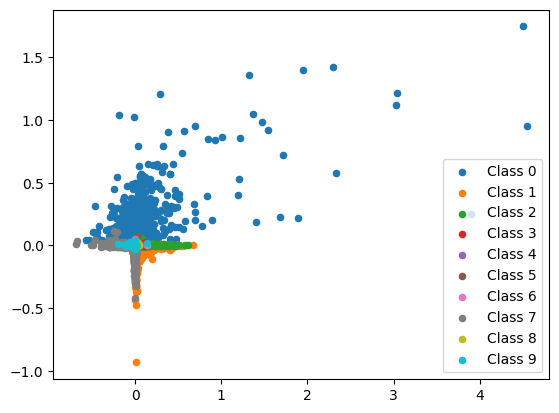

In [17]:
####### Latent Space for VAE

model1=VAE_MLP(28*28,[512,256,128,64],2)# choosing the general model
model1.load_state_dict(torch.load('best_vae_mlp_model.pth')) # loading trained model
model1=to_device(model1,device)

all_labels = []
all_z=[]
for images,labels in train_loader:
    input_data=torch.reshape(images,(-1,784))
    recon,mu,logvar=model1(input_data)# Calculating mu and logvar
    var=torch.exp(logvar) # var is e^logvar
    batch_size=len(images)
    # for every one image, we need to sample one z from the latent space,
    # so we need to sampling for all batch
    for i in range(batch_size):
        # We produce eps as a random variable to sample from the latent space
        # This eps must have zero mean and one var.

        eps=torch.randn(2).to(device)+mu[i]
        z=torch.tensor([(var[i,0]*eps[0]), (var[i,1]*eps[1])])# reparametrization trick for sampling from latent space
        z=z.to('cpu')
        labels=labels.to('cpu')
        all_labels.append(labels[i])
        all_z.append(z)


all_z=np.array(all_z)
all_z_reshaped=np.zeros((60000,2))

for i in range(len(all_z_reshaped)):
  all_z_reshaped[i,:]=all_z[i]


all_labels=np.array(all_labels)

# Latent space is made from two dimension variables, so we will have 60000 numbers with 2 dimensions and 10 labels according
# to number of labels
sizes = list(20 * np.ones(1))
for i in range(10):
    plt.scatter(all_z_reshaped[np.squeeze(all_labels==i),0],
                all_z_reshaped[np.squeeze(all_labels==i),1],
                label=f'Class {i}',
                s=sizes)

plt.legend()


<ipython-input-18-3f09fa43a69a>:37: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  all_z=np.array(all_z)
<ipython-input-18-3f09fa43a69a>:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_z=np.array(all_z)


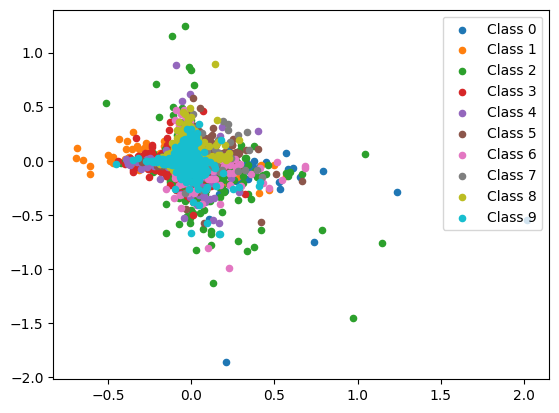

In [18]:
####### Latent Space for CVAE

# This part is adentical to VAE but with a little difference from it.

model2=CVAE_MLP(28*28,[512,256,128,64],2,10)
model2.load_state_dict(torch.load('best_cvae_mlp_model.pth'))


model2=to_device(model2,device)

all_labels = []
all_z=[]
for images,labels in train_loader:

    input_data = torch.reshape(images,(-1,784))

    # One-hot encode the labels
    labels_one_hot=torch.zeros((len(labels),10))
    labels_one_hot=labels_one_hot.to(device)
    for i in range(len(labels_one_hot)):
        labels_one_hot[i,labels[i]]=1

    # The difference is that we have to pass the labels to the model and then all the parts are identical to VAE

    recon, mu, logvar,class_logits = model2.forward(input_data,labels_one_hot)

    var=torch.exp(logvar)
    for i in range(len(mu)):
        eps=torch.randn(2).to(device)+mu[i]
        z=torch.tensor([(var[i,0]*eps[0]), (var[i,1]*eps[1])])
        z=z.to('cpu')
        labels=labels.to('cpu')
        all_labels.append(labels[i])
        all_z.append(z)


all_z=np.array(all_z)
all_z_reshaped=np.zeros((60000,2))

for i in range(len(all_z_reshaped)):
  all_z_reshaped[i,:]=all_z[i]


all_labels=np.array(all_labels)

# Latent space is made from two dimension variables, so we will have 60000 numbers with 2 dimensions and 10 labels according
# to number of labels
sizes = list(20 * np.ones(1))
for i in range(10):
    plt.scatter(all_z_reshaped[np.squeeze(all_labels==i),0],
                all_z_reshaped[np.squeeze(all_labels==i),1],
                label=f'Class {i}',
                s=sizes)

plt.legend()

علت تفاوت برای فضای مخفی اتو انکدر شرطی و اتو انکدر معمولی این است که برای اتو انکدر معمولی، خود مدل یاد میگیرد که چطور باید فضای مخفی را تشکیل دهد که در سمت دیکدر، از آن نمونه بردارد.

اما در اتو انکدر شرطی، به علت اینکه کلاس ها به فضای مخفی، کانکت میشوند اين كه چطور از فضاي خفني نمونه برداري شود، بر عهده‌ي تابع هزينه تشخيص كلاس اتس و لذا خود انکدر میتواند از یک فضای نامنظم نمونه بردارد و طبق تابع هزینه،خودش تصویر مناسب با توجه به لیبل آن تصویر را تولید کند.